In [1]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from IPython.display import clear_output

plt.rcParams['figure.dpi'] = 180
L = keras.layers

In [2]:
# 定义常量
LATENT_DIM = 100 # 潜在空间维度
IMAGE_SHAPE = (28, 28, 1) # 输出图像尺寸
NUM_CLASS = 10

In [3]:
# 生成器模型
noise = L.Input(shape=(LATENT_DIM,))
label = L.Input(shape=(1,), dtype='int32')
label_embedding = L.Embedding(NUM_CLASS, 100, embeddings_initializer='glorot_normal')(label)
model_input = L.multiply([noise, label_embedding])

model = Sequential([
    L.Dense(3 * 3 * 384, input_dim=LATENT_DIM, activation='relu'),
    L.Reshape((3, 3, 384)),
    L.Conv2DTranspose(192, 5, 1, padding='valid',
                      kernel_initializer='glorot_normal'),
    L.Activation("relu"),
    L.BatchNormalization(),

    L.Conv2DTranspose(96, 5, 2, padding='same',
                      kernel_initializer='glorot_normal'),
    L.Activation("relu"),
    L.BatchNormalization(),
    L.Conv2DTranspose(1, 5, 2, padding='same',
                      kernel_initializer='glorot_normal'),
    L.Activation("tanh"),
])

image = model(model_input)

generator = Model([noise, label], image, name='generator')
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1000        input_2[0][0]                    
__________________________________________________________________________________________________
multiply (Multiply)             (None, 1, 100)       0           input_1[0][0]                    
                                                                 embedding[0][0]          

In [4]:
#判别器模型
dis_model = Sequential([
    L.Conv2D(32, 3, padding='same', strides=2,
                    input_shape=(28, 28, 1)),
    L.LeakyReLU(0.2),
    L.Dropout(0.3),

    L.Conv2D(64, 3, padding='same', strides=1),
    L.LeakyReLU(0.2),
    L.Dropout(0.3),

    L.Conv2D(128, 3, padding='same', strides=2),
    L.LeakyReLU(0.2),
    L.Dropout(0.3),

    L.Conv2D(256, 3, padding='same', strides=1),
    L.LeakyReLU(0.2),
    L.Dropout(0.3),

    L.Flatten()
])

img = L.Input(shape=IMAGE_SHAPE)

# Extract feature representation
features = dis_model(img)

# Determine validity and label of the image
validity = L.Dense(1, activation="sigmoid", name='validity')(features)
aux_label = L.Dense(NUM_CLASS, activation="softmax", name='auxiliary')(features)

discriminator = Model(img, [validity, aux_label], name='discriminator')

In [5]:
optimizer = keras.optimizers.Adam(0.0002, 0.5)
# 由于判别是多输出模型，且一个输出为二分类、一个输出为多分类，所以有两个不同的损失函数
losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']

discriminator.compile(loss=losses,
                      optimizer=optimizer,
                      metrics=['accuracy'])
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 12544)        387840      input_3[0][0]                    
__________________________________________________________________________________________________
validity (Dense)                (None, 1)            12545       sequential_1[1][0]               
__________________________________________________________________________________________________
auxiliary (Dense)               (None, 10)           125450      sequential_1[1][0]               
Total params: 525,835
Trainable params: 525,835
Non-trainable params: 0
______________

In [6]:
# 对抗模型
discriminator.trainable = False

# 对抗模型接受噪音和标签作为输入，输出图像真假和标签
noise = L.Input(shape=(LATENT_DIM,))
label = L.Input(shape=(1,))
gen_image = generator([noise, label])

valid_state, target_label = discriminator(gen_image)

optimizer = keras.optimizers.Adam(0.0002, 0.5)
losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']

combined = keras.models.Model([noise, label], [valid_state, target_label])
combined.compile(loss=losses,
                 optimizer=optimizer)
combined.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 28, 28, 1)    2657897     input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
discriminator (Model)           [(None, 1), (None, 1 525835      generator[1][0]              

In [48]:
def sample_images() -> np.array:
    rows, columns = 10, 10

    sampled_labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9] * rows)

    # 生成样本图像
    noise = np.random.uniform(-1, 1, (rows * columns, LATENT_DIM))
    gen_images = generator.predict([noise, sampled_labels])
    gen_images = gen_images * 127.5 + 127.5
    gen_images = gen_images.reshape(len(gen_images), 28, 28).astype(np.uint8)

    fig, axes = plt.subplots(rows, columns, figsize=(4, 4))
    for i, ax in enumerate(axes.flat):
        ax.axis('off')
        ax.imshow(gen_images[i], cmap="gray")

    plt.show()

    return gen_images

In [8]:
def train_acgan(epochs, batch_size=100):
    training_samples = []
    # 加载数据集
    (image_set, label_set), (_, _) = keras.datasets.mnist.load_data()

    # 数据归一化
    image_set = image_set / 127.5 - 1.
    # 数据格式转换 [count, 28, 28] -> [count, 28, 28, 1]
    image_set = image_set.reshape(len(image_set), 28, 28, 1)

    batch_count = int(len(image_set) / batch_size)

    for epoch in range(epochs):
        # 使用 tqdm 生成迭代器，使用方法和 `range(batch)` 一致，但是多了个进度条
        print(f"Epoch {epoch}/{epochs}")
        batch_list = tqdm.trange(batch_count)
        metrics = []
        for index in batch_list:
            # ------- 训练判别器 --------
            # 遍历全部训练数据，确保模型输入多样性
            valid_images = image_set[index * batch_size:(index + 1) * batch_size]
            valid_labels = label_set[index * batch_size:(index + 1) * batch_size]

            # 随机初始噪音和标签，用于生成图像
            noise = np.random.uniform(-1, 1, (batch_size, LATENT_DIM))
            sample_labels = np.random.randint(0, NUM_CLASS, batch_size)

            # 使用生成器生成图像
            gen_images = generator.predict([noise, sample_labels])

            # 训练判别器
            x = np.concatenate((valid_images, gen_images))
            # 使用 Label smoothing 技巧。用 0.95 替代图像正确标签 1
            # 可以避免过拟合，易于训练判别器
            y = np.concatenate(([0.95] * batch_size, [0.0] * batch_size))

            aux_y = np.concatenate((valid_labels, sample_labels))

            # 我们希望判别器只关注图像真伪和真实图像的 label 是否正确
            # 生成图像的 Label 忽略，所以样本损失权重设置为 0
            disc_sample_weight = [np.ones(batch_size * 2), np.ones(batch_size * 2)]
            disc_sample_weight[1][:batch_size] = 2
            disc_sample_weight[1][batch_size:] = 0

            d_state = discriminator.train_on_batch(x, [y, aux_y],
                                                   sample_weight=disc_sample_weight)
            # 使用新的噪音和图像标签生成数据
            noise = np.random.uniform(-1, 1, (2 * batch_size, LATENT_DIM))
            sample_labels = np.random.randint(0, NUM_CLASS, 2 * batch_size)
            trick_labels = np.array([0.95] * 2 * batch_size)
            # 训练生成器
            g_state = combined.train_on_batch([noise, sample_labels],
                                              [trick_labels, sample_labels])
            
            metrics.append([*d_state, *g_state])
        gen_images = sample_images()
        training_samples.append(gen_images)
        
        # 从 metrics 中解析出各个指标的均指
        metrics = np.array(metrics)
        
        dis_loss = np.mean(metrics[:,0])
        dis_gen_loss = np.mean(metrics[:,1])
        dis_aux_loss = np.mean(metrics[:,2])
        
        gen_loss = np.mean(metrics[:,5])
        gen_gen_loss = np.mean(metrics[:,6])
        gen_aux_loss = np.mean(metrics[:,7])
        
        print("component      \t loss \t generation_loss \t auxiliary_loss")
        print("-"*60)
        print(f"generator     \t{dis_loss:.4f} \t{dis_gen_loss:.4f} \t{dis_aux_loss:.4f}")
        print(f"discriminator \t{gen_loss:.4f} \t{gen_gen_loss:.4f} \t{gen_aux_loss:.4f}")

    return training_samples

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 0/20


100%|██████████| 600/600 [01:38<00:00,  6.09it/s]


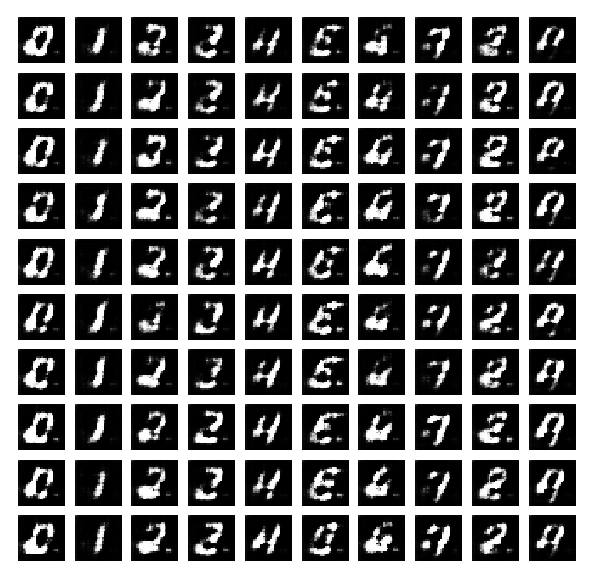

  0%|          | 1/600 [00:00<01:47,  5.59it/s]

component      	 loss 	 generation_loss 	 auxiliary_loss
------------------------------------------------------------
generator     	0.6920 	0.2692 	0.4227
discriminator 	0.8069 	0.4099 	0.3970
Epoch 1/20


100%|██████████| 600/600 [01:37<00:00,  6.17it/s]


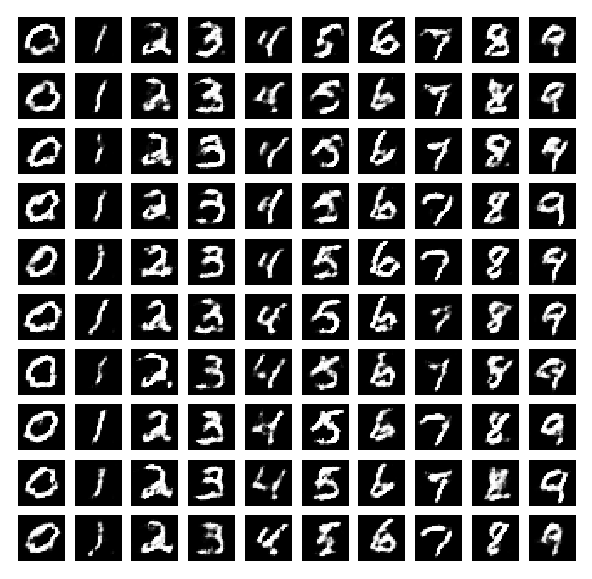

  0%|          | 1/600 [00:00<01:46,  5.62it/s]

component      	 loss 	 generation_loss 	 auxiliary_loss
------------------------------------------------------------
generator     	0.8643 	0.6882 	0.1761
discriminator 	1.0492 	1.0008 	0.0484
Epoch 2/20


100%|██████████| 600/600 [01:37<00:00,  6.18it/s]


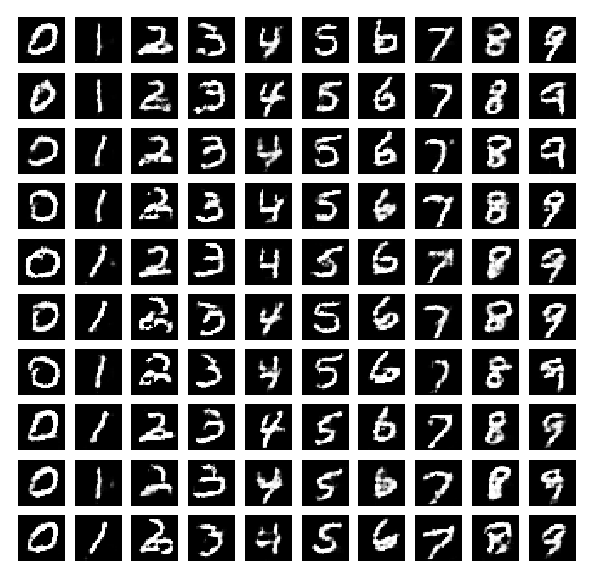

  0%|          | 1/600 [00:00<01:46,  5.62it/s]

component      	 loss 	 generation_loss 	 auxiliary_loss
------------------------------------------------------------
generator     	0.8283 	0.7055 	0.1228
discriminator 	0.8461 	0.8280 	0.0181
Epoch 3/20


100%|██████████| 600/600 [01:37<00:00,  6.16it/s]


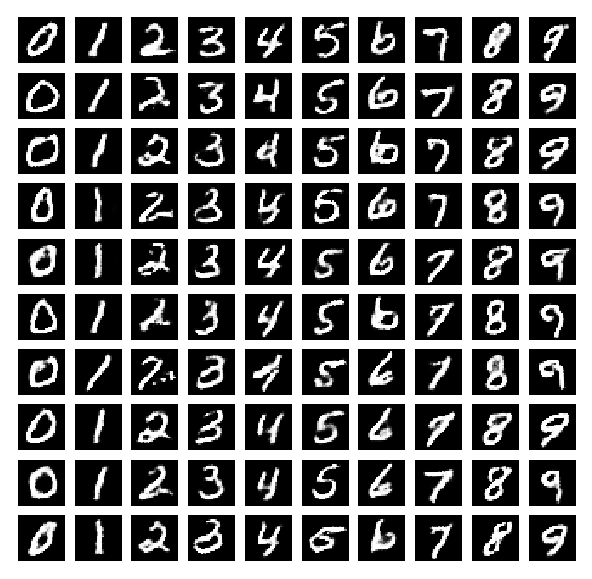

  0%|          | 1/600 [00:00<01:43,  5.77it/s]

component      	 loss 	 generation_loss 	 auxiliary_loss
------------------------------------------------------------
generator     	0.8056 	0.7069 	0.0987
discriminator 	0.8155 	0.8028 	0.0127
Epoch 4/20


100%|██████████| 600/600 [01:36<00:00,  6.22it/s]


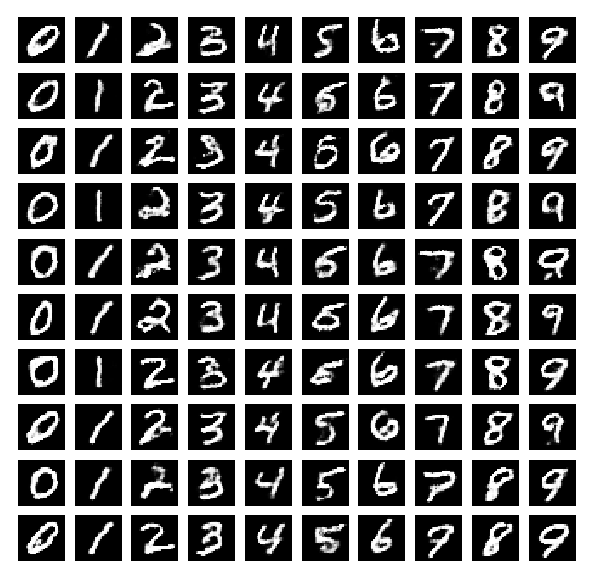

  0%|          | 1/600 [00:00<01:56,  5.13it/s]

component      	 loss 	 generation_loss 	 auxiliary_loss
------------------------------------------------------------
generator     	0.7913 	0.7074 	0.0839
discriminator 	0.7974 	0.7882 	0.0092
Epoch 5/20


100%|██████████| 600/600 [01:40<00:00,  5.97it/s]


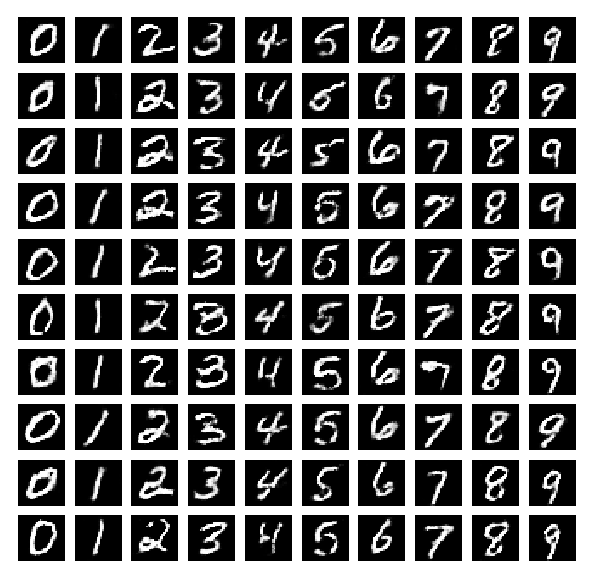

  0%|          | 1/600 [00:00<01:52,  5.33it/s]

component      	 loss 	 generation_loss 	 auxiliary_loss
------------------------------------------------------------
generator     	0.7788 	0.7046 	0.0742
discriminator 	0.7945 	0.7863 	0.0082
Epoch 6/20


100%|██████████| 600/600 [01:40<00:00,  5.97it/s]


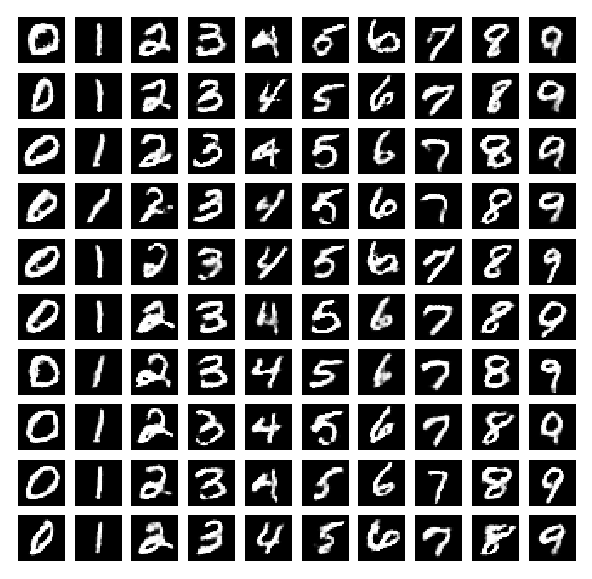

  0%|          | 1/600 [00:00<01:48,  5.54it/s]

component      	 loss 	 generation_loss 	 auxiliary_loss
------------------------------------------------------------
generator     	0.7680 	0.7026 	0.0654
discriminator 	0.7843 	0.7772 	0.0071
Epoch 7/20


100%|██████████| 600/600 [01:40<00:00,  5.99it/s]


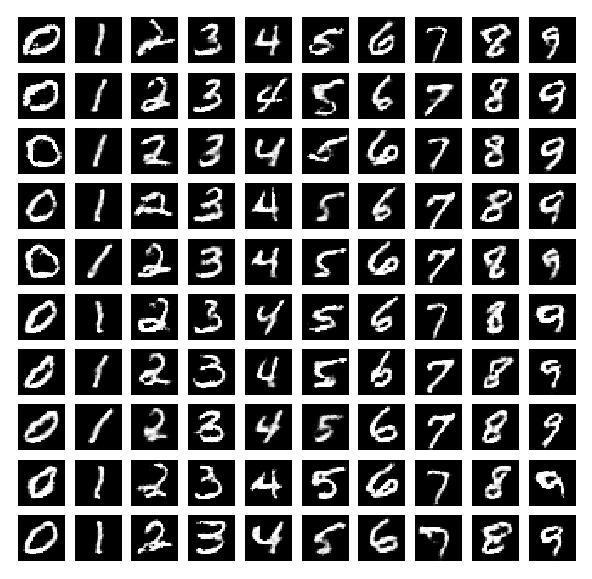

  0%|          | 1/600 [00:00<01:46,  5.63it/s]

component      	 loss 	 generation_loss 	 auxiliary_loss
------------------------------------------------------------
generator     	0.7637 	0.7031 	0.0606
discriminator 	0.7829 	0.7770 	0.0059
Epoch 8/20


100%|██████████| 600/600 [01:40<00:00,  5.96it/s]


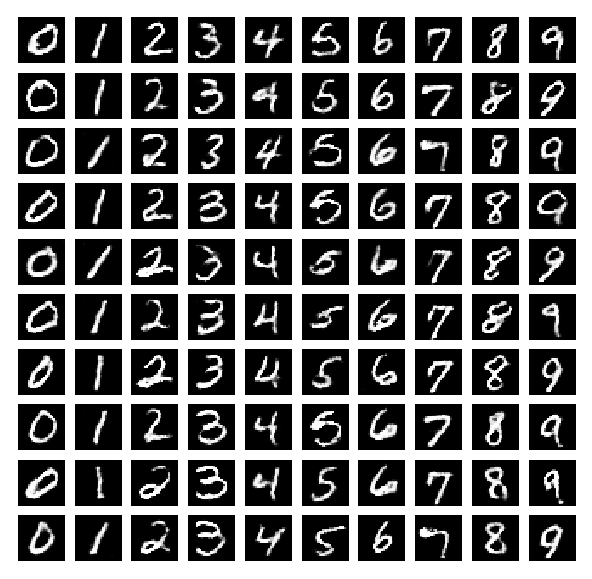

  0%|          | 1/600 [00:00<01:51,  5.35it/s]

component      	 loss 	 generation_loss 	 auxiliary_loss
------------------------------------------------------------
generator     	0.7569 	0.7021 	0.0548
discriminator 	0.7791 	0.7736 	0.0055
Epoch 9/20


100%|██████████| 600/600 [01:40<00:00,  5.95it/s]


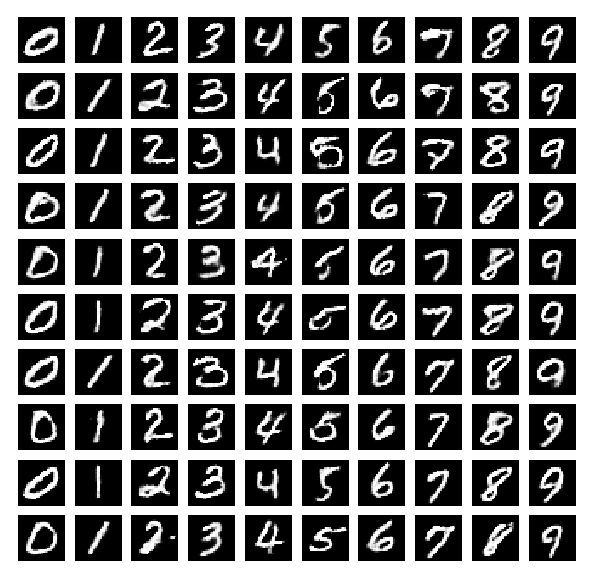

  0%|          | 1/600 [00:00<01:53,  5.29it/s]

component      	 loss 	 generation_loss 	 auxiliary_loss
------------------------------------------------------------
generator     	0.7508 	0.7005 	0.0503
discriminator 	0.7721 	0.7670 	0.0051
Epoch 10/20


100%|██████████| 600/600 [01:40<00:00,  5.96it/s]


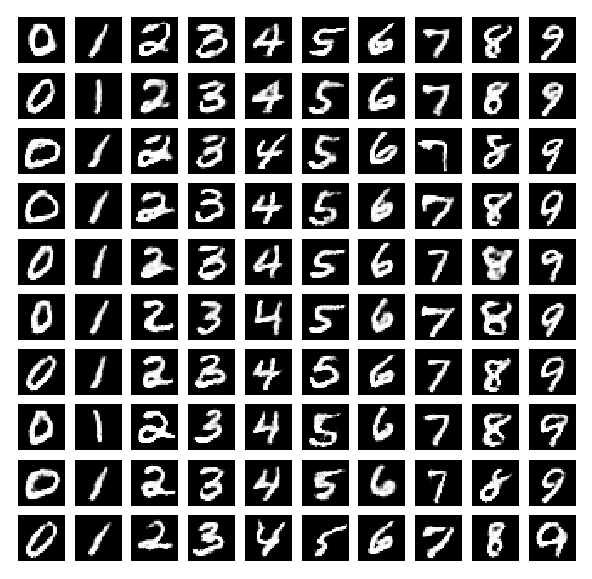

  0%|          | 1/600 [00:00<01:48,  5.52it/s]

component      	 loss 	 generation_loss 	 auxiliary_loss
------------------------------------------------------------
generator     	0.7486 	0.7001 	0.0485
discriminator 	0.7725 	0.7679 	0.0046
Epoch 11/20


100%|██████████| 600/600 [01:40<00:00,  5.95it/s]


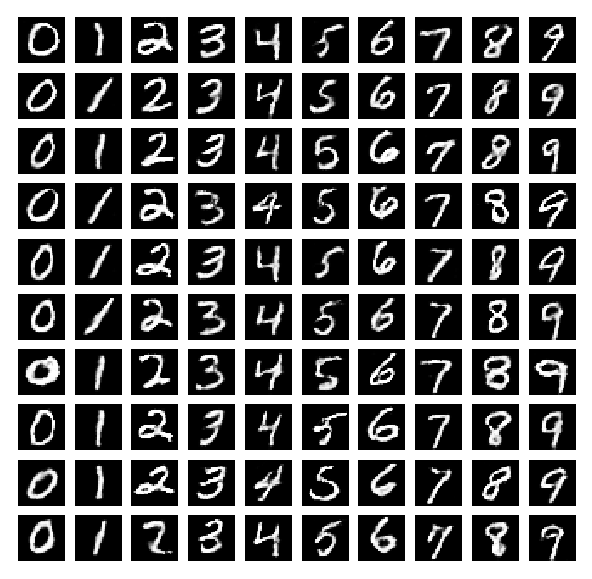

  0%|          | 1/600 [00:00<01:45,  5.66it/s]

component      	 loss 	 generation_loss 	 auxiliary_loss
------------------------------------------------------------
generator     	0.7439 	0.7001 	0.0438
discriminator 	0.7743 	0.7703 	0.0041
Epoch 12/20


100%|██████████| 600/600 [01:40<00:00,  5.95it/s]


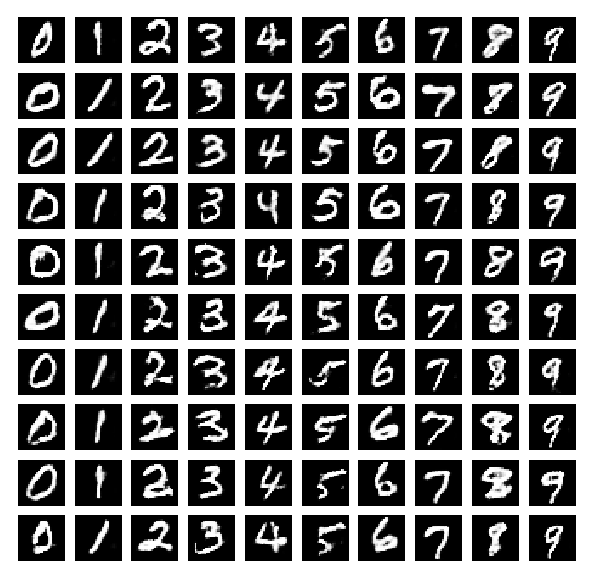

  0%|          | 1/600 [00:00<01:48,  5.50it/s]

component      	 loss 	 generation_loss 	 auxiliary_loss
------------------------------------------------------------
generator     	0.7413 	0.6989 	0.0425
discriminator 	0.7697 	0.7657 	0.0040
Epoch 13/20


100%|██████████| 600/600 [01:41<00:00,  5.92it/s]


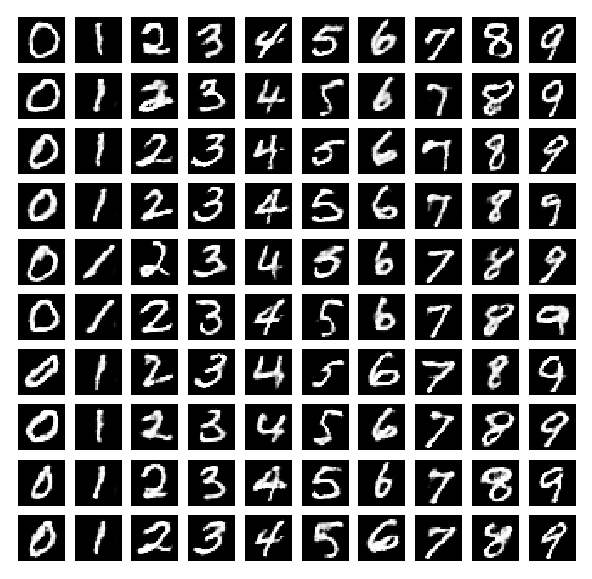

  0%|          | 1/600 [00:00<01:52,  5.33it/s]

component      	 loss 	 generation_loss 	 auxiliary_loss
------------------------------------------------------------
generator     	0.7370 	0.6982 	0.0388
discriminator 	0.7703 	0.7668 	0.0035
Epoch 14/20


100%|██████████| 600/600 [01:41<00:00,  5.89it/s]


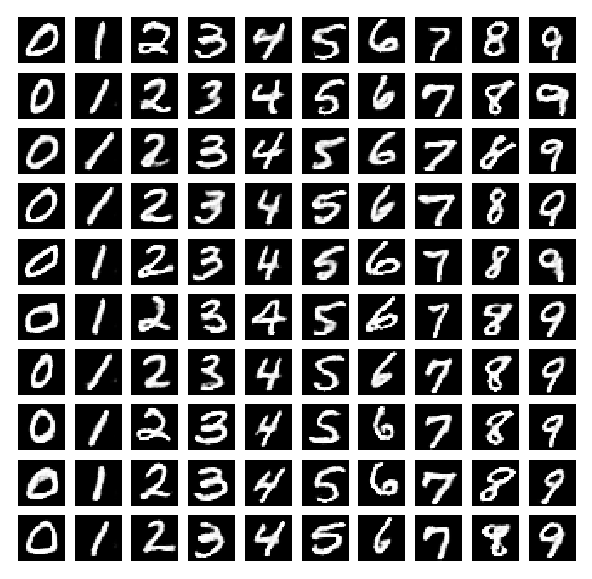

  0%|          | 1/600 [00:00<01:52,  5.32it/s]

component      	 loss 	 generation_loss 	 auxiliary_loss
------------------------------------------------------------
generator     	0.7353 	0.6978 	0.0376
discriminator 	0.7698 	0.7666 	0.0032
Epoch 15/20


100%|██████████| 600/600 [01:42<00:00,  5.87it/s]


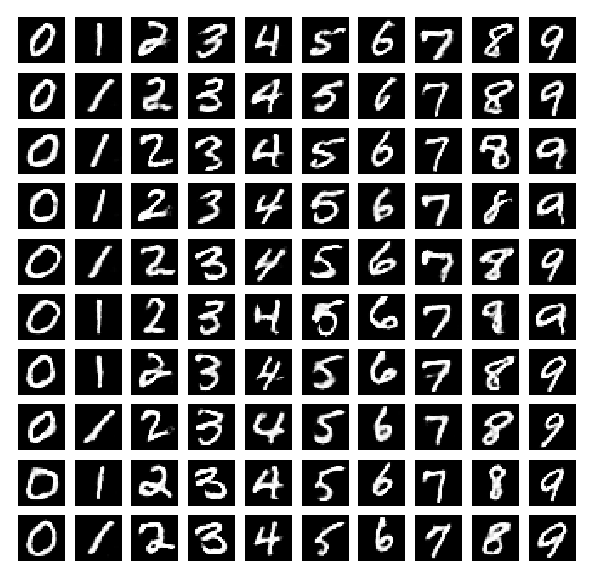

  0%|          | 1/600 [00:00<01:54,  5.23it/s]

component      	 loss 	 generation_loss 	 auxiliary_loss
------------------------------------------------------------
generator     	0.7330 	0.6970 	0.0359
discriminator 	0.7701 	0.7666 	0.0035
Epoch 16/20


100%|██████████| 600/600 [01:43<00:00,  5.80it/s]


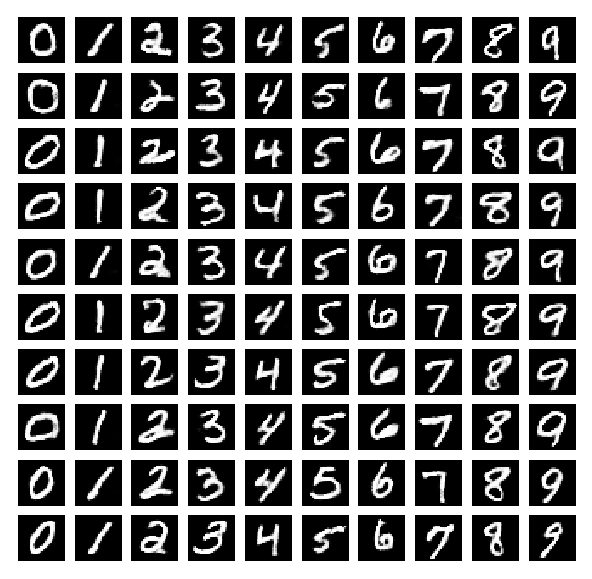

  0%|          | 1/600 [00:00<01:53,  5.26it/s]

component      	 loss 	 generation_loss 	 auxiliary_loss
------------------------------------------------------------
generator     	0.7295 	0.6958 	0.0337
discriminator 	0.7690 	0.7657 	0.0034
Epoch 17/20


100%|██████████| 600/600 [01:40<00:00,  5.95it/s]


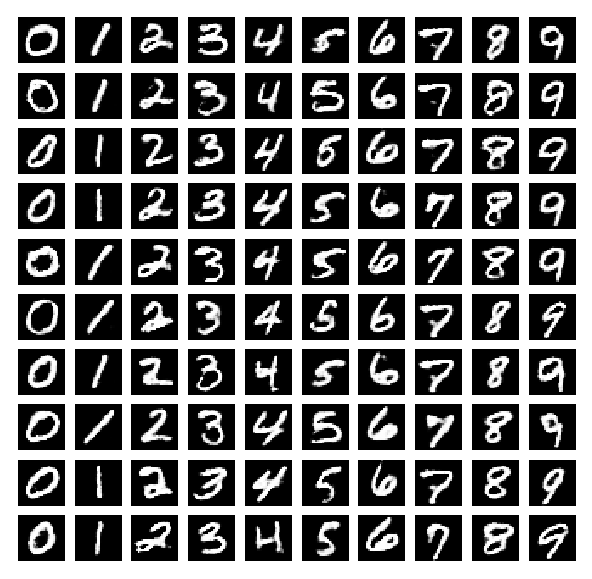

  0%|          | 1/600 [00:00<01:53,  5.26it/s]

component      	 loss 	 generation_loss 	 auxiliary_loss
------------------------------------------------------------
generator     	0.7283 	0.6959 	0.0324
discriminator 	0.7708 	0.7679 	0.0029
Epoch 18/20


100%|██████████| 600/600 [01:41<00:00,  5.88it/s]


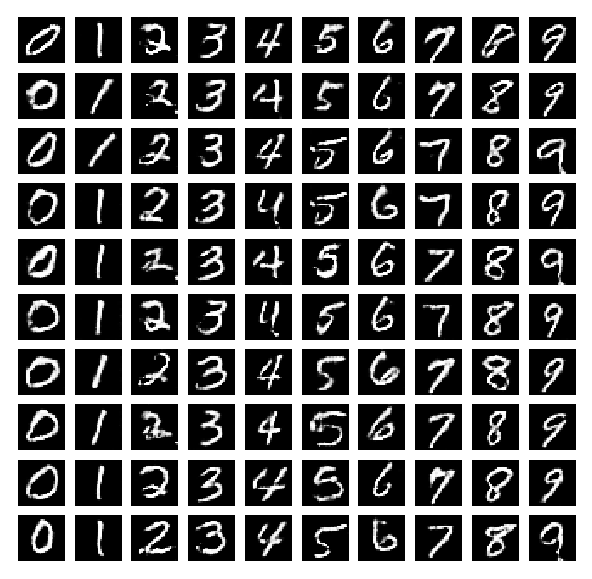

  0%|          | 1/600 [00:00<01:57,  5.09it/s]

component      	 loss 	 generation_loss 	 auxiliary_loss
------------------------------------------------------------
generator     	0.7248 	0.6939 	0.0310
discriminator 	0.7707 	0.7678 	0.0029
Epoch 19/20


100%|██████████| 600/600 [01:41<00:00,  5.90it/s]


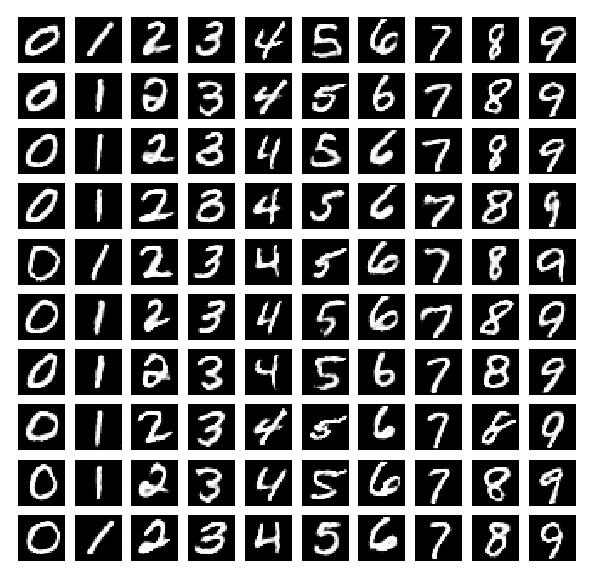

component      	 loss 	 generation_loss 	 auxiliary_loss
------------------------------------------------------------
generator     	0.7238 	0.6934 	0.0303
discriminator 	0.7742 	0.7714 	0.0029


In [9]:
# 开始训练
training_samples = train_acgan(epochs=20)

In [34]:
def visualize_training_process(train_samples):
    nrows, ncols = 3, 7
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 3))
    
    for index, ax in enumerate(axs.flatten()):
        ax.axis('off')
        if index < len(train_samples):
            batch, images = index, train_samples[index]
            row0 = np.concatenate((images[0], images[1], images[2]), axis=1)
            row1 = np.concatenate((images[3], images[4], images[5]), axis=1)
            row2 = np.concatenate((images[6], images[7], images[8]), axis=1)
            image = np.concatenate((row0, row1, row2))
            ax.imshow(image.squeeze(), cmap='gray')
            ax.set_title(batch)        
    plt.show()

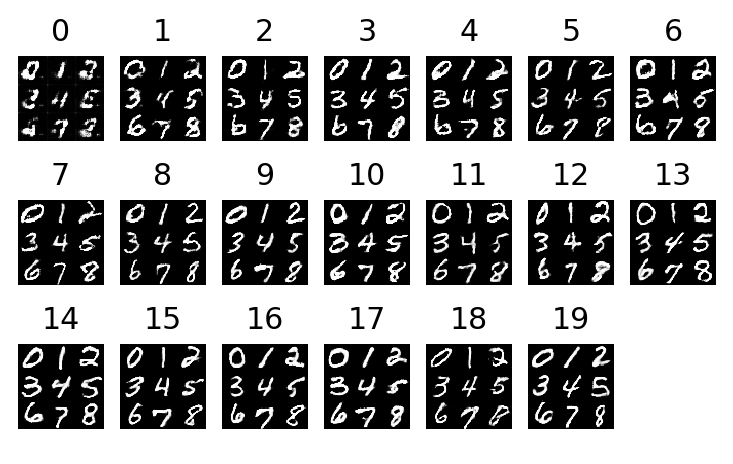

In [35]:
visualize_training_process(training_samples)

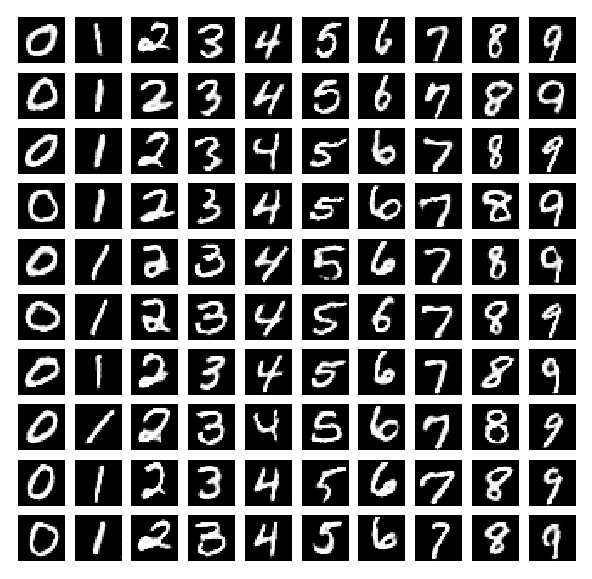

In [42]:
_ = sample_images()